In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [67]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")
plt.rcParams["figure.figsize"] = (10,4)

import warnings
warnings.filterwarnings('ignore')


| **Field**       | **Description**                                                       |
|-----------------|-----------------------------------------------------------------------|
| **Timestamp**   | Recorded time (s)                                                     |
| **CAN ID**      | Identifier of CAN message in HEX (ex. 043f)                           |
| **DLC**         | Number of data bytes, from 0 to 8                                     |
| **DATA[0~7]**   | Data value (byte)                                                     |
| **Flag**        | T or R, where T represents injected message and R represents normal message |

In [3]:
Bytes = ['byte'+str(i) for i in range(1,9)]
Bytes.append('flag')
Bytes

['byte1',
 'byte2',
 'byte3',
 'byte4',
 'byte5',
 'byte6',
 'byte7',
 'byte8',
 'flag']

In [4]:
cols = ['timestamp', 'can_id', 'dlc']
cols.extend(Bytes)
print(cols)

['timestamp', 'can_id', 'dlc', 'byte1', 'byte2', 'byte3', 'byte4', 'byte5', 'byte6', 'byte7', 'byte8', 'flag']


In [5]:
all_data = glob.glob('/content/gdrive/MyDrive/Hacking Cars/*')
all_data

['/content/gdrive/MyDrive/Hacking Cars/DoS_dataset.csv',
 '/content/gdrive/MyDrive/Hacking Cars/Fuzzy_dataset.csv',
 '/content/gdrive/MyDrive/Hacking Cars/gear_dataset.csv',
 '/content/gdrive/MyDrive/Hacking Cars/RPM_dataset.csv']

Each CSV file contains identical columns. For instance, when reading the DoS dataset, we encounter both normal and injected messages. To differentiate them, I will modify each injected message in the `flag` column to reflect its hacking type. For example, in the fuzzy dataset, I will change "T" to "fuzzy". Afterward, I will concatenate all the datasets.

In [6]:
hack_type = [path.split('/')[-1].split('_dataset.csv')[0] for path in all_data]
hack_type

['DoS', 'Fuzzy', 'gear', 'RPM']

In [7]:
data = pd.DataFrame()
for file_path, hack_name in zip(all_data, hack_type):
    df = pd.read_csv(file_path)
    df.columns = cols
    df['flag'] = df['flag'].replace({'T':hack_name})
    data = pd.concat([data, df], ignore_index=True)

data.head()

,timestamp,can_id,dlc,byte1,byte2,byte3,byte4,byte5,byte6,byte7,byte8,flag
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [8]:
data.shape

(16569471, 12)

In [9]:
data['flag'].value_counts(normalize=True)

flag
R        0.857563
RPM      0.040009
gear     0.036487
DoS      0.035893
Fuzzy    0.030048
Name: proportion, dtype: float64

> Our dataset contains approximately 16 million rows, with about 85% of them being normal messages, indicating an imbalance. However, given the large size of the data, I will initially try downsampling while modeling.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16569471 entries, 0 to 16569470
Data columns (total 12 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  float64
 1   can_id     object 
 2   dlc        int64  
 3   byte1      object 
 4   byte2      object 
 5   byte3      object 
 6   byte4      object 
 7   byte5      object 
 8   byte6      object 
 9   byte7      object 
 10  byte8      object 
 11  flag       object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.5+ GB


In [11]:
data.isna().sum()

timestamp         0
can_id            0
dlc               0
byte1             0
byte2             0
byte3             0
byte4        147211
byte5        147211
byte6        147211
byte7        200662
byte8        200665
flag         200665
dtype: int64

In [12]:
data['dlc'].value_counts()

dlc
8    16368806
2      147211
5       53451
6           3
Name: count, dtype: int64

In [14]:
dlc2 = data[data['dlc']==2]
dlc2

,timestamp,can_id,dlc,byte1,byte2,byte3,byte4,byte5,byte6,byte7,byte8,flag
35,1.478198e+09,05f0,2,01,00,R,NaN,NaN,NaN,NaN,NaN,NaN
134,1.478198e+09,05f0,2,01,00,R,NaN,NaN,NaN,NaN,NaN,NaN
226,1.478198e+09,05f0,2,01,00,R,NaN,NaN,NaN,NaN,NaN,NaN
319,1.478198e+09,05f0,2,01,00,R,NaN,NaN,NaN,NaN,NaN,NaN
411,1.478198e+09,05f0,2,01,00,R,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16569051,1.478201e+09,05f0,2,01,00,R,NaN,NaN,NaN,NaN,NaN,NaN
16569143,1.478201e+09,05f0,2,01,00,R,NaN,NaN,NaN,NaN,NaN,NaN
16569236,1.478201e+09,05f0,2,01,00,R,NaN,NaN,NaN,NaN,NaN,NaN
16569328,1.478201e+09,05f0,2,01,00,R,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
dlc5 = data[data['dlc']==5]
print('Data Shape : ' , dlc5.shape)
dlc5.isna().sum()

Data Shape :  (53451, 12)


timestamp        0
can_id           0
dlc              0
byte1            0
byte2            0
byte3            0
byte4            0
byte5            0
byte6            0
byte7        53451
byte8        53451
flag         53451
dtype: int64

In [19]:
dlc6 = data[data['dlc']==6]
print('Data Shape : ' , dlc6.shape)
dlc6.isna().sum()

Data Shape :  (3, 12)


timestamp    0
can_id       0
dlc          0
byte1        0
byte2        0
byte3        0
byte4        0
byte5        0
byte6        0
byte7        0
byte8        3
flag         3
dtype: int64

When the `DLC` (number of data bytes, ranging from 0 to 8) is any number not equal to 8, the `flag` column often contains NaN values. Therefore, we need to drop any row that has NaN in the `flag` (dependent column).

In [21]:
data.dropna(subset=['flag'], inplace=True)
data.shape

(16368806, 12)

In [22]:
data.isna().sum()

timestamp    0
can_id       0
dlc          0
byte1        0
byte2        0
byte3        0
byte4        0
byte5        0
byte6        0
byte7        0
byte8        0
flag         0
dtype: int64

In [71]:
data.duplicated().sum()

2644344

In [72]:
data.drop_duplicates(inplace=True)
data.shape

(13724462, 12)

In [73]:
for col in data.columns[1:]:
  print(f'{col} : {data[col].nunique()}')

can_id : 2048
dlc : 1
byte1 : 256
byte2 : 256
byte3 : 256
byte4 : 256
byte5 : 256
byte6 : 256
byte7 : 256
byte8 : 256
flag : 5


In [74]:
data.drop(columns=['dlc'], inplace=True)
data.head(2)

,timestamp,can_id,byte1,byte2,byte3,byte4,byte5,byte6,byte7,byte8,flag
0,1.478198e+09,018f,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,19,21,22,30,08,8e,6d,3a,R


In [75]:
# Save the DataFrame as a CSV file
df.to_csv('/content/gdrive/MyDrive/Hacking Cars/full_data.csv', index=False)

print("DataFrame saved")

DataFrame saved


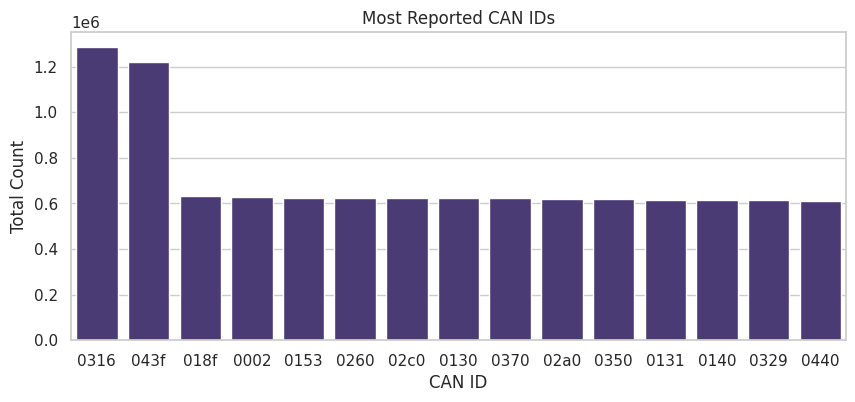

In [76]:
sns.countplot(x='can_id', data=data, order=data['can_id'].value_counts().index[:15])
plt.title('Most Reported CAN IDs')
plt.xlabel('CAN ID')
plt.ylabel('Total Count')
plt.show()

In [32]:
grouped_canId_flag = data.groupby('can_id')['flag'].value_counts().to_frame().reset_index()
grouped_canId_flag.head(20)

,can_id,flag,count
0,0000,DoS,587521
1,0000,Fuzzy,247
2,0001,Fuzzy,214
3,0002,R,773581
4,0002,Fuzzy,241
5,0003,Fuzzy,234
6,0004,Fuzzy,212
7,0005,Fuzzy,230
8,0006,Fuzzy,219
9,0007,Fuzzy,258


In [54]:
grouped_canId_flag_num = data.groupby('can_id')['flag'].nunique().to_frame().reset_index()
grouped_canId_flag_num.head(3)

,can_id,flag
0,0000,2
1,0001,1
2,0002,2


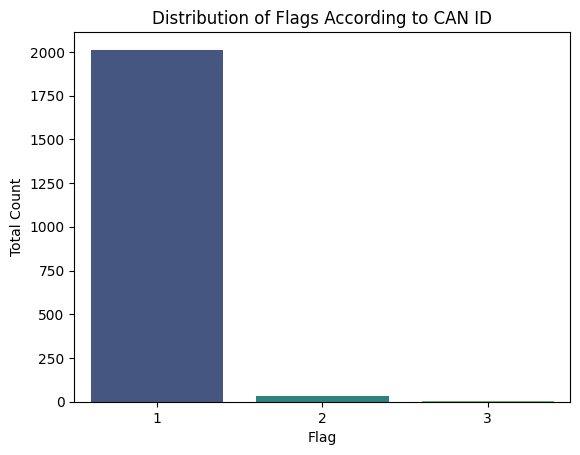

In [55]:
sns.countplot(x='flag', data=grouped_canId_flag_num, palette='viridis')
plt.title('Distribution of Flags According to CAN ID')
plt.xlabel('Flag')
plt.ylabel('Total Count')
plt.show()

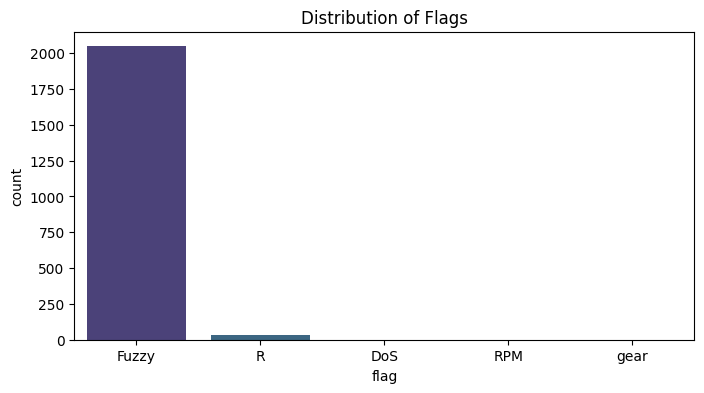

In [51]:
plt.figure(figsize=(8, 4))
sns.countplot(x='flag', data=grouped_canId_flag, palette='viridis', order=grouped_canId_flag['flag'].value_counts().index)
plt.title('Distribution of Flags')
plt.show()

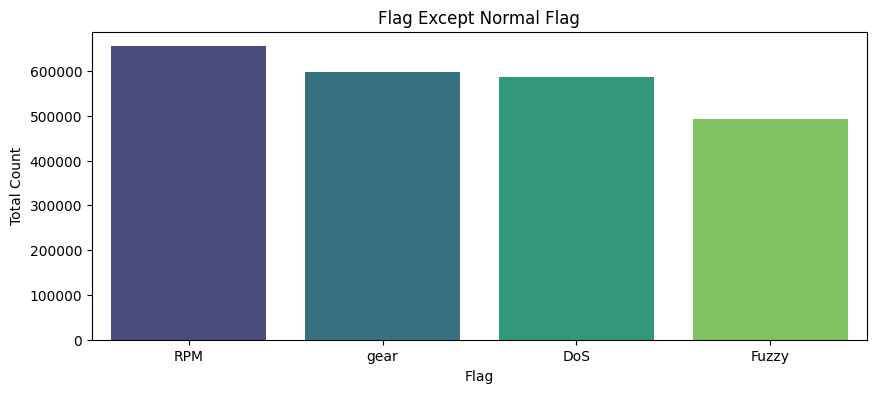

In [53]:
plt.figure(figsize=(10, 4))
sns.countplot(x='flag', data=data, palette='viridis', order=data['flag'].value_counts().index[1:])
plt.title('Flag Except Normal Flag')
plt.xlabel('Flag')
plt.ylabel('Total Count')
plt.show()

**Conclusions from Previous Graphs:**

- Most `can_id` values have only one flag, while some have two flags.
- The most prevalent attack on most `can_id` values is fuzzy.
- Overall, all types of attacks are approximately equal in frequency.